## Categorical Perception: A Groundwork for Deep Learning
#### Laurent Bonnasse-Gahot & Jean-Pierre Nadal
Python notebook for reproducing the results presented in Section 3.2.3, Figures 3 (Examples of image continua) and 5 (Gradual categorical perception across layers), as well as Figure B.1.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# for reproducibility
SEED = 1
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rc={'font.size': 11, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('ticks')

In [2]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

In [3]:
if not os.path.exists('fig'):
    os.makedirs('fig')

In [4]:
n_classes = 10

(x_train, y_train), (x_test, y_test) =  mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

input_shape = (np.prod(x_train.shape[1:]),)

In [5]:
batch_size = 128
n_epochs = 50
n_hid = 256

input_x = Input(shape=input_shape)
x = Dense(n_hid, activation='relu')(input_x)
x = Dropout(0.2)(x)
x = Dense(n_hid, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(n_hid, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(input_x, x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))), 
          tf.keras.utils.to_categorical(y_train, n_classes),
          batch_size=batch_size,
          epochs=n_epochs,
          validation_data=(x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))),
                           tf.keras.utils.to_categorical(y_test, n_classes)),
          verbose=1)

Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 0.5772 - accuracy: 0.8205 - val_loss: 0.1184 - val_accuracy: 0.9648
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1435 - accuracy: 0.9567 - val_loss: 0.0965 - val_accuracy: 0.9702
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1022 - accuracy: 0.9679 - val_loss: 0.0768 - val_accuracy: 0.9761
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0740 - accuracy: 0.9767 - val_loss: 0.0712 - val_accuracy: 0.9767
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0637 - accuracy: 0.9799 - val_loss: 0.0771 - val_accuracy: 0.9790
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0547 - accuracy: 0.9831 - val_loss: 0.0617 - val_accuracy: 0.9812
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0490 - accuracy: 0.9834 - val_loss: 0.0670 - val_accuracy: 0.9806
Epoch 

In [6]:
# autoencoder that will be used to create the morphings
encoder = load_model('model/mnist_encoder_cnn.h5')
decoder = load_model('model/mnist_decoder_cnn.h5')

In [7]:
encoded_imgs = encoder(x_test).numpy()

In [8]:
idx_per_class = [np.flatnonzero(y_test == i) for i in range(n_classes)]

n_samples_perclass = 100
    
pairs_between = []
for i in range(9):
    for j in range(i+1,10):
        for k1, k2 in zip(idx_per_class[i][0:n_samples_perclass], idx_per_class[j][0:n_samples_perclass]):
            pairs_between.append([k1,k2])

In [9]:
def get_continuum(encoded_imgs, k1, k2, n):
    act1 = encoded_imgs[k1]
    act2 = encoded_imgs[k2]
    alpha_rg = np.linspace(0.,1.,n)
    img_continuum = []
    act_alpha = []
    for alpha in alpha_rg:
        act_alpha.append((1-alpha)*act1 + alpha*act2)
    img_continuum = decoder(np.array(act_alpha)).numpy()
    return img_continuum

def cosine_distance(act1, act2):
    return (1 - np.dot(act1, act2)/(np.linalg.norm(act1)*np.linalg.norm(act2)))

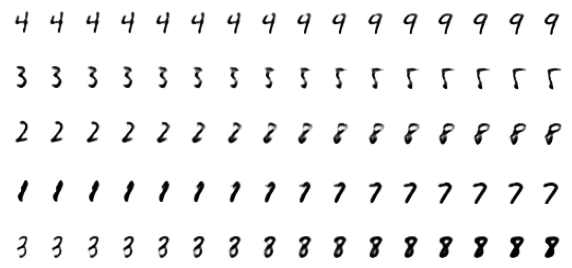

In [10]:
examples = [3402, 2574, 2223, 1425, 2848]

# Figure 3: Example of an image continuum
n_morphs = 16

fh, axes = plt.subplots(5, n_morphs, figsize=(10, 5))
for j, k in enumerate(examples):
    k1, k2 =  pairs_between[k]
    img_continuum = get_continuum(encoded_imgs, k1, k2, n_morphs)
    for i, img in enumerate(img_continuum):
        ax = axes[j,i]
        ax.imshow(img.reshape(28, 28), cmap='gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
plt.show()
fh.savefig('fig/mnist_continua_examples.pdf', bbox_inches='tight')

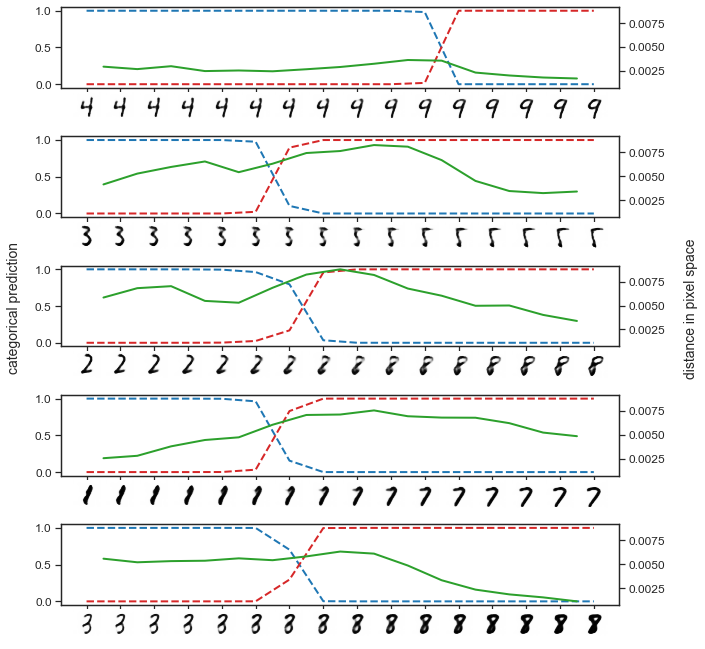

In [11]:
fh, axes = plt.subplots(5, 1, figsize=(10, 11), sharex=True, sharey=True)

for j, k in enumerate(examples):
    k1, k2 =  pairs_between[k]
    img_continuum = get_continuum(encoded_imgs, k1, k2, n_morphs)

    pred = model(img_continuum.reshape(n_morphs, -1)).numpy()[:,[y_test[k1], y_test[k2]]]

    input_distance = [cosine_distance(img_continuum[i].flatten(), img_continuum[i+1].flatten())
                       for i in range(n_morphs-1)]

    ax1 = axes[j]
    ax1.plot(pred[:,0], color='tab:blue', ls='--', lw=2)
    ax1.plot(pred[:,1], color='tab:red', ls='--', lw=2)
    ax1.set_xticks(np.arange(n_morphs))
    ax1.set_xticklabels('')
    
    ax2 = ax1.twinx()    
    ax2.plot(.5+np.arange(n_morphs-1), input_distance, color='tab:green', lw=2)
    
    if j > 0:
        ax2.get_shared_y_axes().join(ax2, previous_ax2)        
    previous_ax2 = ax2
        
    for i, img in enumerate(img_continuum):
        imgtmp = np.repeat(255*(1-img), 3, axis=2).astype('uint8')
        ab = AnnotationBbox(OffsetImage(imgtmp, zoom=1.0),
                            (i, -0.3), 
                            frameon=False, annotation_clip=False)
        ax1.add_artist(ab)
          
plt.subplots_adjust(hspace=0.6)  
    
fh.text(0.05, 0.5, 'categorical prediction', va='center', rotation='vertical', fontsize=rc['axes.labelsize'])
fh.text(0.99, 0.5, 'distance in pixel space', va='center', rotation='vertical', fontsize=rc['axes.labelsize'])
plt.show()

fh.savefig('fig/mnist_continua_examples_input_distance_pred.pdf', bbox_inches='tight')

In [12]:
n_morphs = 50

# need to restrict to cases that interpolate nicely between the two categories (and only these two)
# for that need to have the sum of the pred almost equal to 1
thsld = 0.95

# all the curves are going to be aligned with the boundary between the two categories
# need to dismiss cases where their boundary is too close to the extremities
# n_morphs_margin = minimal number of images on either side of the boundary
n_morphs_margin = 10

In [13]:
hidden_layers = [layer for layer in model.layers 
                 if layer.name.startswith('dense')][:-1]
hidden_outputs = [layer.output for layer in hidden_layers]
activation_model = Model(inputs=model.input, outputs=hidden_outputs)

In [14]:
alpha_range = np.linspace(-n_morphs_margin/n_morphs , n_morphs_margin/n_morphs, 2*n_morphs_margin+1)
alpha_discrim_range = .5*(alpha_range[:-1]+alpha_range[1:])

df_pred = []
df_neural_dist = []

index_pair = 0

for k1, k2 in pairs_between:
    img_continuum = get_continuum(encoded_imgs, k1, k2, n_morphs)
    pred = model(img_continuum.reshape(n_morphs, -1)).numpy()[:,[y_test[k1], y_test[k2]]]
    inflexion_idx = np.argmin(np.abs(pred[:,0]-0.5))
    
    if (np.all(np.sum(pred, axis=1) > thsld) 
        & (inflexion_idx >= n_morphs_margin) & (inflexion_idx < (n_morphs - n_morphs_margin))):
        img_continuum = get_continuum(encoded_imgs, k1, k2, n_morphs)
        pred = model(img_continuum.reshape(n_morphs, -1)).numpy()[:,[y_test[k1], y_test[k2]]]
        
        df_pred.append(pd.DataFrame(
                {'alpha':alpha_range,
                 'pred1':pred[inflexion_idx-n_morphs_margin:inflexion_idx+n_morphs_margin+1,0],
                 'pred2':pred[inflexion_idx-n_morphs_margin:inflexion_idx+n_morphs_margin+1,1],
                 'pair':index_pair*np.ones(2*n_morphs_margin+1, dtype=int)}))

        activation_layers = activation_model(img_continuum.reshape(n_morphs, -1))

        neural_distance_layers = [[cosine_distance(activation_layer[i], activation_layer[i+1])
                                   for i in range(n_morphs-1)]
                                  for activation_layer in activation_layers]
        
        for layer, neural_distance_layer in enumerate(neural_distance_layers):
            df_neural_dist.append(pd.DataFrame(
                {'layer':layer+1,
                 'alpha_discrim':alpha_discrim_range,
                 'neural_dist':neural_distance_layer[inflexion_idx-n_morphs_margin:inflexion_idx+n_morphs_margin],
                 'pair':index_pair*np.ones(2*n_morphs_margin, dtype=int)}))
            
        index_pair += 1
        
df_pred = pd.concat(df_pred)
df_neural_dist = pd.concat(df_neural_dist)

# how many pairs in the end ?
print(index_pair)

1650


In [15]:
n_layers = len(hidden_layers)

color_layer = sns.cubehelix_palette(n_colors=n_layers, start=0.3, rot=0.3,
                                    light=0.75, dark=0.2, hue=0.8 , gamma=0.9)

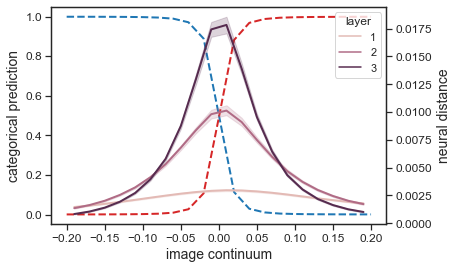

In [16]:
fh = plt.figure(figsize=(6,4))
ax1 = plt.subplot(111)
sns.lineplot(x='alpha', y='pred1', data=df_pred, ci=None,
             lw=2, ls='--', color='tab:blue', ax=ax1)
sns.lineplot(x='alpha', y='pred2', data=df_pred, ci=None,
             lw=2, ls='--', color='tab:red', ax=ax1)

ax2 = ax1.twinx() 
sns.lineplot(x='alpha_discrim', y='neural_dist', hue='layer', data=df_neural_dist,
             palette = color_layer,
             lw=2, ax=ax2)
ax1.set_xlabel('image continuum')
ax1.set_ylabel('categorical prediction')
ax2.set_ylabel('neural distance')
plt.show()

fh.savefig('fig/mnist_mlp_neuraldistance_layers.pdf', bbox_inches='tight')